<a href="https://colab.research.google.com/github/mequanent/Music-Recommendation-Exercises/blob/main/LightGCN%20using%20Pytorch%20Geometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: LightGCN with PyTorch Geometric from [Medium](https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e).

@hhotta@stanford.edu

In [2]:
# To install the correct version of Pytorch Geometric.
# This cell is modified from: https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7

import torch

TORCH_version = torch.__version__
CUDA_version = torch.version.cuda

TORCH = TORCH_version.split('+')[0]
CUDA = 'cu' + CUDA_version.replace('.', '')

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric 

     |████████████████████████████████| 7.9 MB 2.7 MB/s 
     |████████████████████████████████| 3.5 MB 3.6 MB/s 
     |████████████████████████████████| 2.5 MB 2.6 MB/s 
     |████████████████████████████████| 750 kB 2.5 MB/s 
     |████████████████████████████████| 407 kB 5.5 MB/s 


# Implementing a Recommender System using LightGCN

In this colab, we explain how to set up a graph recommender system using the [LighGCN](https://arxiv.org/abs/2002.02126) model. Specifically, we apply LightGCN to a movie recommendation task using [PyTorch](https://pytorch.org/) and [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/).

We use the [MovieLens](https://grouplens.org/datasets/movielens/) (*small*) dataset which has 100,000 ratings applied to 9,000 movies by 600 users. 

Our implementation was inspired by the following documentation and repositories:
- https://github.com/gusye1234/LightGCN-PyTorch
- https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch
- https://pytorch-geometric.readthedocs.io/en/latest/notes/load_csv.html

In [3]:
# import required modules
from pathlib import Path
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as prep

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

# Loading the Dataset

We load the dataset and set ratings >=4 on a 0.5 ~ 5 scale as an edge between users and movies.

We split the edges of the graph using a 80/10/10 train/validation/test split.

In [4]:
# Movie
# download the dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'

Extracting ./ml-latest-small.zip


In [3]:
# Music
metaurl = "http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Digital_Music.json.gz"
reviewurl = "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Digital_Music.json.gz"
ratingurl = "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music.csv"

columns = ['movieId','userId','rating','timestamp']
meta = pd.read_json(metaurl, lines = True)
review = pd.read_json(reviewurl, lines = True)
rating = pd.read_csv(ratingurl, names=columns, header = None)

# Re-order the user and item columns
columns = ['userId','movieId','rating','timestamp']
rating = rating.reindex(columns=columns)
rating.head(2)

moviecols = ['movieId',	'title',	'genres'] # For music review

In [4]:
df = rating[rating['rating']>4]
df.shape

(1280147, 4)

In [ ]:
len(df['userId'].value_counts().index.tolist())

713286

In [5]:
#a = df['userId'].value_counts().index.tolist()[:-60000]
a = df['userId'].value_counts().index.tolist()[48000:]
df = df.loc[df['userId'].isin(a)]
df.shape

(857275, 4)

In [6]:
u = review.asin.unique().tolist()
v = meta.asin.unique().tolist()
n = df.movieId.unique().tolist()
m = set(n).intersection(v, u)

print(len(u), len(n), len(v), len(m))

met = meta.loc[meta['asin'].isin(m)]
rev = review.loc[review['asin'].isin(m)]
rat = df.loc[rating['movieId'].isin(m)]

456992 294140 66013 42791


In [ ]:
# Original
u = review.asin.unique().tolist()
v = meta.asin.unique().tolist()
n = rating.movieId.unique().tolist()
m = set(n).intersection(v, u)

print(len(u), len(n), len(v), len(m))

met = meta.loc[meta['asin'].isin(m)]
rev = review.loc[review['asin'].isin(m)]
rat = rating.loc[rating['movieId'].isin(m)]

456992 456992 66013 66010


In [8]:
a = rev[['asin']]
b = met[['asin', 'title', 'brand']]
a_b = pd.merge(a, b, on = 'asin', how = 'inner').drop_duplicates()
a_b.rename(columns = {'asin': 'movieId', 'brand': 'genres'}, inplace = True) 
ratng = pd.merge(rat, a_b, on = 'movieId', how = 'inner')
ratng = ratng[:100000]

In [ ]:
ratng.shape

In [ ]:
# Original
a = rev[['asin']]
b = met[['asin', 'title', 'brand']]
existing = ['asin'	'title'	'brand']
a_b = pd.merge(a, b, on = 'asin', how = 'inner').drop_duplicates()
#a_b[a_b['asin']=='B00NPZI1ZS']['title'].values[0]
a_b.rename(columns = {'asin': 'movieId', 'brand': 'genres'}, inplace = True) 
# ['movieId',	'title',	'genres']
ratng = pd.merge(rat, a_b, on = 'movieId', how = 'inner')
ratng

In [9]:
leu = prep.LabelEncoder() # ['userId','movieId','rating','timestamp']
lem = prep.LabelEncoder()

ratng['movieId'] = leu.fit_transform(ratng['movieId'].values)
ratng['userId'] = lem.fit_transform(ratng['userId'].values)
ratng.head(2)

,userId,movieId,rating,timestamp,title,genres
0,23808,1,5.0,1387670400,So You Wanna Go Back to Egypt,Keith Green
1,76028,1,5.0,1378857600,So You Wanna Go Back to Egypt,Keith Green


In [10]:
ratings = ratng[['userId', 'movieId',	'rating',	'timestamp'	]]
movie = ratng[['movieId',	'title',	'genres'	]].drop_duplicates()

In [ ]:
movie

In [11]:
#path = Path('/content/drive/MyDrive/Colab Notebooks/') 
path = Path('./ml-latest-small/')
movie_file = path/'movie.csv'
rating_file = path/'rating.csv'

#movie.to_csv(movie_file,columns = ['movieId',	'title',	'genres'], index=False)#  sep=' ')
movie.to_csv(movie_file, index=False)
ratings.to_csv(rating_file, index=False)
#ratings.to_csv(rating_file, columns = ['userId',	'movieId',	'rating',	'timestamp'])#, sep=' ')
#np.savetxt(movie_file, movie, fmt='%s')
#np.savetxt(rating_file, ratings, fmt='%s')

In [42]:
movie_path = './ml-latest-small/movie.csv'
rating_path = './ml-latest-small/rating.csv'

In [13]:
r = pd.read_csv(movie_path)
r.head(2) 

,movieId,title,genres
0,1,So You Wanna Go Back to Egypt,Keith Green
1,2,Early Works - Dallas Holm,Dallas Holm


In [5]:
# load user and movie nodes
def load_node_csv(path, index_col):
    """Loads csv containing node information

    Args:
        path (str): path to csv file
        index_col (str): column name of index column

    Returns:
        dict: mapping of csv row to node id
    """ 
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping


user_mapping = load_node_csv(rating_path, index_col='userId')
movie_mapping = load_node_csv(movie_path, index_col='movieId')

In [6]:
# load edges between users and movies
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold


    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)


edge_index = load_edge_csv(
    rating_path,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='movieId',
    dst_mapping=movie_mapping,
    link_index_col='rating',
    rating_threshold=4,
)

In [7]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_users, num_movies = len(user_mapping), len(movie_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [8]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))

In [9]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# Implementing LightGCN

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}

## Matrix Form
In our implementation, we utilize the matrix form of LightGCN. We perform multi-scale diffusion to obtain the final embedding, which sums embeddings diffused across multi-hop scales. 

\begin{equation}
E^{(K)} = \alpha_0 E^{(0)} + \alpha_1 \tilde{A}^1 E^{(0)} + \alpha_2 \tilde{A}^2 E^{(0)} + \cdot \cdot \cdot + \alpha_K \tilde{A}^K \tilde{A} E^{(0)}
\end{equation}

$E^{(0)} \in \mathcal{R}^{(M + N)} \times T$ : stacked initial item and user embeddings where $M$, $N$, and $T$ denote the number of users, number of items, and the dimension of each embedding respectively

$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ : symmetrically normalized adjacency matrix



In [ ]:
# Modified Aggregation
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=True): # add_self_loops=False originally
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
    #def __init__(self, nn, embedding_dim=32, **kwargs):
        #super(GINPNAConv, self).__init__(nn, **kwargs)
        super().__init__()
        self.mlp = nn.Linear(embedding_dim*12, embedding_dim) # modification
        self.delta = 2.5749     # modification

        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final_sum = torch.sum(embs, dim=1) # E^K
        emb_final_mean = torch.mean(embs, dim=1)
        emb_final_max = torch.max(embs, dim=1)[0]
        #emb_final_min = torch.min(embs, dim=1)[0]
        emb_final_std = torch.std(embs, dim=1)


        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

model = LightGCN(num_users, num_movies)

In [29]:
s = torch.sum(b, dim = 1)
mn = torch.mean(b, dim = 1)
mx = torch.max(b, dim = 1)[0]
st = torch.std(b, dim = 1)

In [31]:
mlp = nn.Linear(64*12, 64) # modification
delta = 2.5749

In [ ]:
index = torch.min(b, dim = 1)[1]
index

In [33]:
aggrs = [s, mx, mn, st]
c_idx = index.bincount().float().view(-1, 1)
l_idx = torch.log(c_idx + 1.)
        
amplification_scaler = [c_idx / delta * a for a in aggrs]
attenuation_scaler = [delta / c_idx * a for a in aggrs]
combinations = torch.cat(aggrs + amplification_scaler + attenuation_scaler, dim=1)
x = mlp(combinations)
x

IndexError: ignored

tensor([[  3.7524,   1.7524,   7.7524,   6.7524,   5.7524],
        [ -8.2273, -10.2273,  -4.2273,  -5.2273,  -6.2273],
        [ -2.6800,  -4.6800,   1.3200,   0.3200,  -0.6800],
        [  2.5842,   0.5842,   6.5842,   5.5842,   4.5842],
        [ 12.2485,  10.2485,  16.2485,  15.2485,  14.2485],
        [ -1.1481,  -3.1481,   2.8519,   1.8519,   0.8519],
        [ -2.8417,  -4.8417,   1.1583,   0.1583,  -0.8417],
        [ -3.5658,  -5.5658,   0.4342,  -0.5658,  -1.5658],
        [  5.5001,   3.5001,   9.5001,   8.5001,   7.5001],
        [  2.7301,   0.7301,   6.7301,   5.7301,   4.7301],
        [  4.9473,   2.9473,   8.9473,   7.9473,   6.9473],
        [  4.6801,   2.6801,   8.6801,   7.6801,   6.6801],
        [  4.4888,   2.4888,   8.4888,   7.4888,   6.4888],
        [  5.1431,   3.1431,   9.1431,   8.1431,   7.1431],
        [ -3.4150,  -5.4150,   0.5850,  -0.4150,  -1.4150],
        [  4.5591,   2.5591,   8.5591,   7.5591,   6.5591],
        [  5.9248,   3.9248,   9.9248,  

In [12]:
a = torch.randint(10, (5,))
b = a + (torch.randn(50, 1) * 5).float()

In [10]:
# Original
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

model = LightGCN(num_users, num_movies)

# Loss Function



We utilize a Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2 
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [11]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{nDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

In [12]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [13]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [14]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [15]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [16]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    print("items_emb_final", items_emb_final)
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

# Training

Your test set performance should be in line with the following (*K=20*):

*Recall@K: 0.13, Precision@K: 0.045, NDCG@K: 0.10*

In [17]:
# define constants
ITERATIONS = 10000
#ITERATIONS = 100
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
#ITERS_PER_EVAL = 5
#ITERS_PER_LR_DECAY = 5
K = 20
LAMBDA = 1e-6

In [18]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("CUDA: ", device)
print(f"Using device {device}.")

model = model.to(device)
model.train()

print("CUDA: ", device)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

CUDA:  cuda
Using device cuda.
CUDA:  cuda


In [24]:
torch.cuda.current_device()

0

In [19]:
torch.device('cuda')

device(type='cuda')

In [20]:
# training loop
train_losses = []
val_losses = []

neg_items_emb_final2 = neg_items_emb_02 = items_emb_final2 = items_emb_02 = neg_item_indices2 = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]

    items_emb_final2, items_emb_02, neg_item_indices2 = items_emb_final, items_emb_0, neg_item_indices 
    #neg_item_indices2 = neg_item_indices

    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]
    
    neg_items_emb_final2, neg_items_emb_02 = neg_items_emb_final, neg_items_emb_0
    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

items_emb_final tensor([[-0.0128,  0.0235,  0.0491,  ..., -0.0389,  0.0126, -0.0476],
        [ 0.0037,  0.0241,  0.0082,  ..., -0.0015, -0.0124,  0.0279],
        [-0.0077, -0.0042,  0.0121,  ..., -0.0148, -0.0042, -0.0113],
        ...,
        [ 0.0349,  0.0237,  0.0219,  ...,  0.0196,  0.0421,  0.0109],
        [-0.0604, -0.0379,  0.0692,  ..., -0.0260, -0.0055,  0.0382],
        [ 0.0355, -0.0100, -0.0004,  ..., -0.0044,  0.0151, -0.0102]],
       device='cuda:0', grad_fn=<SplitWithSizesBackward0>)
[Iteration 0/10000] train_loss: -0.69132, val_loss: -0.68386, val_recall@20: 0.00245, val_precision@20: 0.00054, val_ndcg@20: 0.00105
items_emb_final tensor([[-0.0162,  0.0317,  0.0389,  ..., -0.0419,  0.0337, -0.0694],
        [ 0.0158,  0.0147,  0.0041,  ...,  0.0017,  0.0015,  0.0121],
        [-0.0012,  0.0015,  0.0032,  ..., -0.0130,  0.0025, -0.0252],
        ...,
        [ 0.0318,  0.0180,  0.0180,  ...,  0.0186,  0.0361,  0.0114],
        [-0.0590, -0.0465,  0.0688,  ..., -0.028

In [21]:
neg_items_emb_final2

tensor([[ 0.3683, -0.3108,  0.3540,  ...,  0.3342, -0.3758,  0.3297],
        [ 0.0682, -0.0765,  0.0882,  ...,  0.1013, -0.1202,  0.1109],
        [ 0.3298, -0.3559,  0.3319,  ...,  0.3704, -0.3239,  0.3393],
        ...,
        [-0.3662,  0.4021, -0.3583,  ..., -0.4148,  0.4180, -0.3916],
        [ 0.3221, -0.3285,  0.3645,  ...,  0.3541, -0.3404,  0.3344],
        [ 0.2971, -0.3408,  0.3188,  ...,  0.3401, -0.3423,  0.3538]],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [30]:
CUDA_LAUNCH_BLOCKING=1

In [22]:
neg_items_emb_final2 #= neg_items_emb_02 = items_emb_final2 = items_emb_02= neg_item_indices2 

tensor([[ 0.3683, -0.3108,  0.3540,  ...,  0.3342, -0.3758,  0.3297],
        [ 0.0682, -0.0765,  0.0882,  ...,  0.1013, -0.1202,  0.1109],
        [ 0.3298, -0.3559,  0.3319,  ...,  0.3704, -0.3239,  0.3393],
        ...,
        [-0.3662,  0.4021, -0.3583,  ..., -0.4148,  0.4180, -0.3916],
        [ 0.3221, -0.3285,  0.3645,  ...,  0.3541, -0.3404,  0.3344],
        [ 0.2971, -0.3408,  0.3188,  ...,  0.3401, -0.3423,  0.3538]],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [ ]:
items_emb_final2

tensor([[-1.0282, -1.0481,  1.0157,  ..., -1.0355,  1.0884, -1.0639],
        [-0.7572, -0.7609,  0.7687,  ..., -0.8248,  0.7711, -0.7784],
        [-0.4236, -0.4398,  0.4595,  ..., -0.4678,  0.4368, -0.4822],
        ...,
        [ 0.3525,  0.3575, -0.3669,  ...,  0.3379, -0.3289,  0.3242],
        [ 0.3598,  0.3243, -0.3419,  ...,  0.2763, -0.2763,  0.3306],
        [ 0.2264,  0.2349, -0.3058,  ...,  0.2632, -0.2883,  0.2931]],
       grad_fn=<SplitWithSizesBackward0>)

In [ ]:
items_emb_02

Parameter containing:
tensor([[-4.1128, -4.1926,  4.0630,  ..., -4.1419,  4.3537, -4.2557],
        [-3.0289, -3.0437,  3.0750,  ..., -3.2992,  3.0845, -3.1135],
        [-1.6943, -1.7591,  1.8378,  ..., -1.8714,  1.7473, -1.9287],
        ...,
        [ 1.4102,  1.4301, -1.4675,  ...,  1.3516, -1.3156,  1.2969],
        [ 1.4391,  1.2973, -1.3676,  ...,  1.1051, -1.1052,  1.3224],
        [ 0.9054,  0.9398, -1.2234,  ...,  1.0529, -1.1533,  1.1724]],
       requires_grad=True)

In [ ]:
items_emb_02[neg_item_indices2]

tensor([[ 1.4593,  1.4769, -1.3761,  ...,  1.3603, -1.1518,  1.3259],
        [-0.8510, -0.9326,  0.7929,  ..., -0.8131,  0.7023, -1.0383],
        [ 1.0182,  1.1052, -0.8752,  ...,  0.8988, -1.0389,  0.8718],
        ...,
        [ 1.3499,  1.4397, -1.3728,  ...,  1.5476, -1.3881,  1.4515],
        [-0.6660, -0.6483,  0.7554,  ..., -0.6244,  0.6193, -0.6034],
        [-3.4670, -3.4076,  3.3600,  ..., -3.4073,  3.2948, -3.4103]],
       grad_fn=<IndexBackward0>)

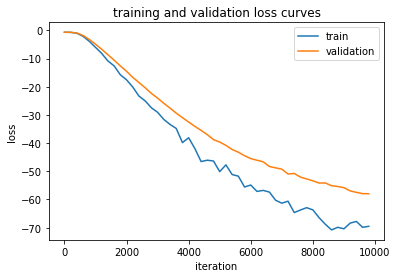

In [ ]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [ ]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -52.53061, test_recall@20: 0.12583, test_precision@20: 0.04638, test_ndcg@20: 0.10166


# Make New Recommendatios for a Given User

In [ ]:
model.eval()
df = pd.read_csv(movie_path)
movieid_title = pd.Series(df.title.values,index=df.movieId).to_dict()
movieid_genres = pd.Series(df.genres.values,index=df.movieId).to_dict()

user_pos_items = get_user_positive_items(edge_index)

In [ ]:
def make_predictions(user_id, num_recs):
    user = user_mapping[user_id]
    e_u = model.users_emb.weight[user]
    scores = model.items_emb.weight @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)

    movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some movies that user {user_id} rated highly")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

    print()

    movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some suggested movies for user {user_id}")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

In [ ]:
USER_ID = 1
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

Here are some movies that user 1 rated highly
title: Forrest Gump (1994), genres: Comedy|Drama|Romance|War 
title: Matrix, The (1999), genres: Action|Sci-Fi|Thriller 
title: Silence of the Lambs, The (1991), genres: Crime|Horror|Thriller 
title: Star Wars: Episode IV - A New Hope (1977), genres: Action|Adventure|Sci-Fi 
title: Fight Club (1999), genres: Action|Crime|Drama|Thriller 
title: Schindler's List (1993), genres: Drama|War 
title: Star Wars: Episode V - The Empire Strikes Back (1980), genres: Action|Adventure|Sci-Fi 
title: Braveheart (1995), genres: Action|Drama|War 
title: American Beauty (1999), genres: Drama|Romance 
title: Usual Suspects, The (1995), genres: Crime|Mystery|Thriller 

Here are some suggested movies for user 1
title: Shawshank Redemption, The (1994), genres: Crime|Drama 
title: Pulp Fiction (1994), genres: Comedy|Crime|Drama|Thriller 
title: Godfather, The (1972), genres: Crime|Drama 
title: Terminator 2: Judgment Day (1991), genres: Action|Sci-Fi 
title: Lor

In [ ]:
USER_ID = 1
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

Here are some movies that user 1 rated highly
title: Forrest Gump (1994), genres: Comedy|Drama|Romance|War 
title: Matrix, The (1999), genres: Action|Sci-Fi|Thriller 
title: Silence of the Lambs, The (1991), genres: Crime|Horror|Thriller 
title: Star Wars: Episode IV - A New Hope (1977), genres: Action|Adventure|Sci-Fi 
title: Fight Club (1999), genres: Action|Crime|Drama|Thriller 
title: Schindler's List (1993), genres: Drama|War 
title: Star Wars: Episode V - The Empire Strikes Back (1980), genres: Action|Adventure|Sci-Fi 
title: Braveheart (1995), genres: Action|Drama|War 
title: Usual Suspects, The (1995), genres: Crime|Mystery|Thriller 
title: Star Wars: Episode VI - Return of the Jedi (1983), genres: Action|Adventure|Sci-Fi 

Here are some suggested movies for user 1
title: Shawshank Redemption, The (1994), genres: Crime|Drama 
title: Pulp Fiction (1994), genres: Comedy|Crime|Drama|Thriller 
title: Godfather, The (1972), genres: Crime|Drama 
title: Terminator 2: Judgment Day (199